Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Importing Skin Cancer Data**

In [2]:
## If we are using the data by mounting the google drive, we use the following code:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
## Defining the path for train and test images

root_path = "/content/gdrive/MyDrive/Data/CNN_assignment"
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
## Counting number of images in train and test directory

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Observation : This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

We are using 80% of the images for training, and 20% for validation.

In [6]:
## Load train dataset
## Using 80% of the images for training, and 20% for validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,labels='inferred', validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Load validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,labels='inferred', validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### We will visualize one instance of all the nine classes present in the dataset and show one random image from each class

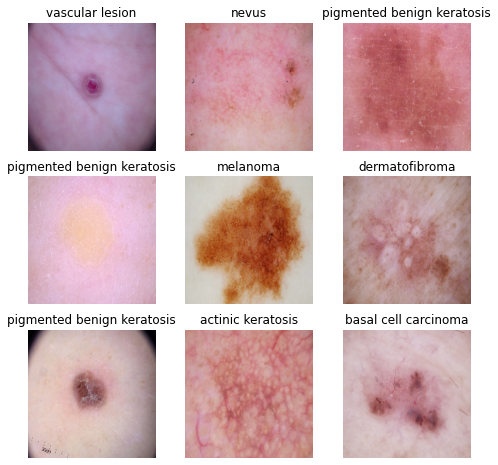

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the basic model 
#### We will create basic model without regularization and optimisation
#### Rescaling to normalize pixel values between (0,1)
#### Model will have 3 convolutional units having a convolutional layers followed by max pooling layer  followed by flattening layer and fully connected laye
 

In [11]:
## Normalisation layer to scale the RGB value to 0 and 1

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [12]:
## define the layer of CNN model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ## 1st convolutional layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## 2nd convolutional layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## 3rd convolutional layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## Convert layer into 1-D
  layers.Flatten(),
  ## Fully connected layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
## View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
## We will the train model for 20 epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 91s 1s/step - loss: 1.9724 - accuracy: 0.2628 - val_loss: 1.7854 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 56s 1s/step - loss: 1.5835 - accuracy: 0.4431 - val_loss: 1.5215 - val_accuracy: 0.4989
Epoch 3/20
56/56 [==============================] - 60s 1s/step - loss: 1.3918 - accuracy: 0.5156 - val_loss: 1.5854 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 56s 996ms/step - loss: 1.3271 - accuracy: 0.5530 - val_loss: 1.3802 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 55s 989ms/step - loss: 1.2083 - accuracy: 0.5753 - val_loss: 1.3680 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 55s 980ms/step - loss: 1.1209 - accuracy: 0.6094 - val_loss: 1.4292 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 55s 984ms/step - loss: 1.0578 - accuracy: 0.6166 - val_loss: 1.4089 - val_accuracy: 0.5615
Epoch 8/

### Visualizing training results

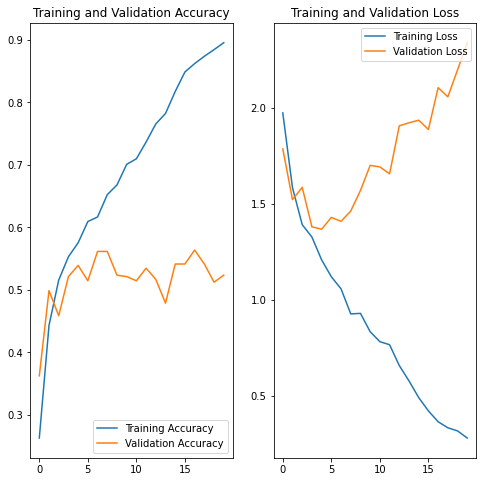

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation : Difference between training and validation accuracy is higher and this is the sign of overfitting. The training accuracy is 89.56% while the validation accuracy is 52.35% which is clearly the sign of overfitting. From the loss diagram, we can see that the model loss is decreasing continuously with each epoch with it's learning but for the validation set this loss was decreasing at first few epoch then it started increasing which shows that the loss has increased during the testing  on validation set. To overcome this issue we use data augmentation. Data augmentation generates additional training data from existing examples by augmenting them using random transformations that yield believable looking images.

### Data Augumentation

In [16]:
## Define the data augementation pipeline

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

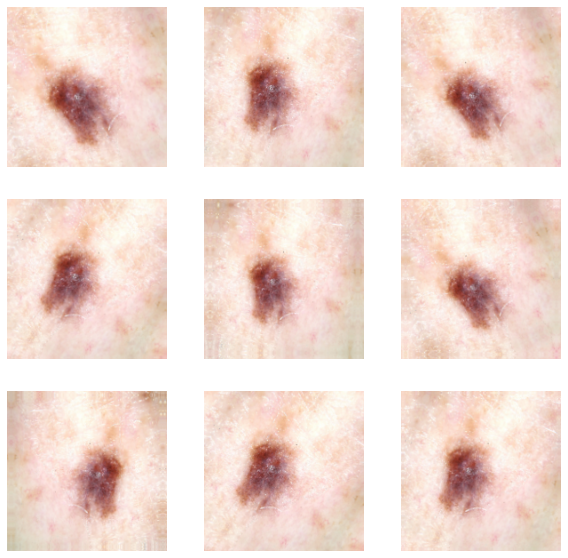

In [17]:
##  To visualize augmentation strategy we will visualise one  instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model
### Model will have 3 convolutional units having a convolutional layers followed by max pooling layer. This will be followed by flattening layer and fully connected layer. We also add a dropout of 0.2 to reduce overfitting.




In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [19]:
## Compile the model and also viewing model summary

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [ ]:
## We train our model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 70s 1s/step - loss: 2.0693 - accuracy: 0.2360 - val_loss: 1.8012 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 67s 1s/step - loss: 1.8350 - accuracy: 0.3237 - val_loss: 1.8099 - val_accuracy: 0.3154
Epoch 3/20
34/56 [=================>............] - ETA: 26s - loss: 1.6829 - accuracy: 0.3741

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation : After applying data augmentation and Dropout, there is less overfitting than before as training and validation accuracy are closer than before. Training accuracy : 62.95, Validation accuracy  55.93. This result shows data augmentation solve our model overfitting problem.

## Class imbalance
### Find the distribution of classes in the training dataset.

In [ ]:
## # show the distribution of the number of images for each label

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### seborrhetic keratosis class has least number of samples
#### melanoma, pigmented benign keratosis, basal cell carcinoma, nevus classes are dominating in data sets
#### We can clearly observe class imbalance in the dataset which can effect our model. We will rectify class imbalances by Augmentor


In [ ]:
# install Augmentor is necessary

!pip install Augmentor

In [ ]:
## To use `Augmentor`, the following general procedure is followed:

# 1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.
# 2. Define a number of operations to perform on this data set using your `Pipeline` object.
# 3. Execute these operations by calling the `Pipeline’s` `sample()` method.


path_to_training_dataset="/content/gdrive/MyDrive/Data/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
## Count of image after adding above

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### find the distribution of augmented data after adding new images to the original training data.

In [ ]:
## List of path of files in the training directory having agumented images as well

from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
## List of path of files in the training directory

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
## Build a dictorary of path and labels

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
## Creating dataframe of the above dictionary

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = (df2)

In [ ]:
## Count of each classes after solving class imbalance problem

new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
## Load the train dataset
## We will use 80:20 split for train and validation

data_dir_train="/content/gdrive/MyDrive/Data/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

### Create our model.
#### Model will have 3 convolutional units having a convolutional layer followed by max pooling layer. Followed by flattening layer and fully connected layer.
#### We will include BatchNormalisation to reduce overfitting.
#### We also include dropout layer to reduce overfitting.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

### Compile the model
##### We have chosen Adam optimiser and SparseCategoricalCrossentropy loss function for model training.

In [ ]:
## Compile our model and also viewing model summary.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

#### **Todo:**  Train your model

In [ ]:
## Train our model on 30 epochs

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
##### Accuracy on training data has increased by using Augmentor library. The model has achieved a training accuracy of 81.05% and validation accuracy of 77.36% which shows us we finally get rid of overfitting. There is less overfitting than before as training and validation accuracy are closer than before. 
##### After reducing class imbalance, tuning the learning rate, the accuracy has increases significantly and also solved problem of overfitting. 



In [ ]:
data_dir_test = '/content/gdrive/MyDrive/Data/CNN_assignment/Test/'
test_ds = image_dataset_from_directory(
    data_dir_test,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(test_ds.class_names)

normalised_layer = tf.keras.layers.Rescaling(1./255)
test_ds1 = test_ds.map(lambda x, y: (normalised_layer(x), y))

model.evaluate(test_ds1)
model.evaluate(train_ds)
model.evaluate(val_ds)